# Data Visualization Exam

In [1]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import numpy as np

## Data acquisition
CSV file creation from raw data and loading the CSV file into the program.

In [2]:
dataFolderName = "data"
fileName = dataFolderName + '/DCSC_RACLI_01092021113430630.csv'
df = pd.read_csv(fileName)      # load data from CSV to program
df.head() # data loaded

,ITTER107,Territorio,TIPO_DATO7,Tipo dato,SEXISTAT1,Sesso,ETA1_A,Classe di età,PROFILO_PROF,Qualifica contrattuale,ATECO_2007,Ateco 2007,CLLVT,Classe di dipendenti,TIME,Seleziona periodo,Value,Flag Codes,Flags
0,IT,Italia,HOUWAG_ENTEMP_AV_MI,Retribuzione lorda oraria per ora retribuita d...,9,totale,TOTAL,totale,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2014,2014,14.48,NaN,NaN
1,IT,Italia,HOUWAG_ENTEMP_AV_MI,Retribuzione lorda oraria per ora retribuita d...,9,totale,TOTAL,totale,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2015,2015,14.80,NaN,NaN
2,IT,Italia,HOUWAG_ENTEMP_AV_MI,Retribuzione lorda oraria per ora retribuita d...,9,totale,TOTAL,totale,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2016,2016,14.80,NaN,NaN
3,IT,Italia,HOUWAG_ENTEMP_AV_MI,Retribuzione lorda oraria per ora retribuita d...,9,totale,TOTAL,totale,6,operaio,B,estrazione di minerali da cave e miniere,TOTAL,totale,2017,2017,15.05,NaN,NaN
4,IT,Italia,HOUWAG_ENTEMP_AV_MI,Retribuzione lorda oraria per ora retribuita d...,9,totale,TOTAL,totale,99,totale,B,estrazione di minerali da cave e miniere,W50_249,50-249,2014,2014,20.24,NaN,NaN


## Data parsing

In [3]:
# TODO: Check for errors in data
#       total is equal to the arithmetic mean of the parts? not seem
#       find missing data
#   	check that value apprendista < operaio < dirigente (for territory)

print('\nBefore remove duplicates: ' + str(len(df)) + ' rows')
df.drop_duplicates()
print('After remove duplicates:  ' + str(len(df)) + ' rows')

# are values reasonable?
print('\nMin value is ' + str(df['Value'].min()))
print('Max value is ' + str(df['Value'].max()))

# TODO: Change type

# TODO: Choose the level for hierachical data


# TODO: Transform the data
df['Territorio'] = df['Territorio'].str.replace(' / ','/')


Before remove duplicates: 12142 rows
After remove duplicates:  12142 rows

Min value is 6.38
Max value is 46.29


## Data filtering

In [4]:
df2 = df.copy()

# unique data
del df2['TIPO_DATO7'] # always the same (HOUWAG_ENTEMP_AV_MI)
del df2['Tipo dato']  # always the same (Retribuzione lorda oraria per ora retribuita delle posizioni lavorative dipendenti in euro (media).)

# ridondance of information
df2 = df2.drop(['SEXISTAT1', 'ETA1_A','PROFILO_PROF','CLLVT','Seleziona periodo'], axis=1)
# del df2['ATECO_2007']

df2 = df2[df2['Flag Codes'] != 'c'] # delete incomplete data

del df2['Flags']
del df2['Flag Codes']

df2.head()

,ITTER107,Territorio,Sesso,Classe di età,Qualifica contrattuale,ATECO_2007,Ateco 2007,Classe di dipendenti,TIME,Value
0,IT,Italia,totale,totale,operaio,B,estrazione di minerali da cave e miniere,totale,2014,14.48
1,IT,Italia,totale,totale,operaio,B,estrazione di minerali da cave e miniere,totale,2015,14.80
2,IT,Italia,totale,totale,operaio,B,estrazione di minerali da cave e miniere,totale,2016,14.80
3,IT,Italia,totale,totale,operaio,B,estrazione di minerali da cave e miniere,totale,2017,15.05
4,IT,Italia,totale,totale,totale,B,estrazione di minerali da cave e miniere,50-249,2014,20.24


## Data mining

In [5]:
# granularity of sectors exists only for entire Italy (no territorial granularity)
df_sectors = df2.query('`Ateco 2007`!="TOTALE"')

# choose granularity of sectors
df_sectors = df_sectors.query('`ATECO_2007`>="A" & `ATECO_2007`<="Z"')

df_sectors = df_sectors.drop(['Territorio', 'ATECO_2007'], axis=1)

In [6]:
df_territory = df2.query('`Ateco 2007`=="TOTALE"')
df_territory = df_territory.drop(['Ateco 2007', 'ATECO_2007'], axis=1)

In [7]:
# TODO: start with univariate analysis (one variable at a time), continue with multivariate analysis

## Question 1
Do women earn less than men in Italy in private companies? Where is the most difference?

In [8]:
df_sex = df_territory.query('Sesso!="totale"')
df_sex = df_sex.drop(['Classe di età','Qualifica contrattuale','Classe di dipendenti'],axis=1)
len(df_sex)

1078

### Plot line chart

In [9]:
df_sex_tot = df_sex.query('Territorio=="Italia"')

title = 'Gender difference salary in Italy'
labels = ['Men','Women']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)']
mode_size = [8, 8]
line_size = [2, 2]

x_data = np.vstack((np.arange(df_sex_tot.TIME.min(), df_sex_tot.TIME.max()+1),)*2)

df_sex_tot.sort_values(by='TIME')
y_tot_m = df_sex_tot.query('Sesso=="maschi"')
y_tot_w = df_sex_tot.query('Sesso=="femmine"')
y_data = np.array([y_tot_m['Value'],y_tot_w['Value']])

fig = go.Figure()

for i in range(0, 2):
    fig.add_trace(go.Scatter(x=x_data[i], y=y_data[i], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))

    # endpoints
    fig.add_trace(go.Scatter(
        x=[x_data[i][0], x_data[i][-1]],
        y=[y_data[i][0], y_data[i][-1]],
        mode='markers',
        marker=dict(color=colors[i], size=mode_size[i])
    ))

fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)'
        )
    ),
    yaxis=dict(
        showgrid=True,
        zeroline=True,
        showline=True,
        showticklabels=True,
        range = [0, max(df_sex_tot['Value'])]
    ),
    autosize=False,
    margin=dict(
        autoexpand=False,
        l=100,
        r=20,
        t=110,
    ),
    showlegend=False,
    plot_bgcolor='white'
)

annotations = []

# Adding labels
for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
                                  xanchor='right', yanchor='middle',
                                  text=label + ' {}'.format(y_trace[0]),
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.95, y=y_trace[2],
                                  xanchor='left', yanchor='middle',
                                  text='{}'.format(y_trace[2]),
                                  font=dict(family='Arial',
                                            size=16),
                                  showarrow=False))
# Title
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
# Source
annotations.append(dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                              xanchor='center', yanchor='top',
                              text='Source: PewResearch Center & ' +
                                   'Storytelling with data',
                              font=dict(family='Arial',
                                        size=12,
                                        color='rgb(150,150,150)'),
                              showarrow=False))

fig.update_layout(annotations=annotations)

fig.show()

### Plot gender map

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import geopandas as gpd
from geopandas import GeoDataFrame

In [11]:
map_df = {}

map_df["map_2014"] = gpd.read_file(f'{dataFolderName}/province_shapes/Prov01012014_g/Prov01012014_g_WGS84.shp')

for year in range(2015,2018):
    fp = f'{dataFolderName}/province_shapes/ProvCM01012017_g/ProvCM01012017_g_WGS84.shp'
    
    map_df[f"map_{year}"] = gpd.read_file(fp) #reading the file stored in variable fp

    map_df[f"map_{year}"].loc[map_df[f"map_{year}"].DEN_PCM=="Aosta","DEN_PCM"] = "Valle d'Aosta/Vallée d'Aoste"
    map_df[f"map_{year}"].loc[map_df[f"map_{year}"].DEN_PCM=="Forli'-Cesena","DEN_PCM"] = "Forlì-Cesena"
    map_df[f"map_{year}"].loc[map_df[f"map_{year}"].DEN_PCM=="Massa Carrara","DEN_PCM"] = "Massa-Carrara"
    map_df[f"map_{year}"].loc[map_df[f"map_{year}"].DEN_PCM=="Bolzano","DEN_PCM"] = "Bolzano/Bozen"

    # print(map_df[f"map_{year}"].plot())
# map_df['map_2015']

In [12]:
# consider only province data
df_sex_province = df_sex[df_sex['ITTER107'].str.contains('.{5}')]

df_sex_province_year = {}
for year in range(2014,2018):
    temp = df_sex_province.query(f'TIME=={year}')
    temp_f = temp.query('Sesso=="maschi"').set_index('ITTER107').drop('Sesso',axis=1)
    temp_d = temp.query('Sesso=="femmine"').set_index('ITTER107')
    temp_f['Value'] = [temp_f['Value'][prov]-temp_d['Value'][prov] for prov in temp['ITTER107'].drop_duplicates()]
    df_sex_province_year[f'group_{year}'] = temp_f

del temp, temp_d, temp_f
# df_sex_province_year["group_2014"]

In [13]:
# merge data with map shapes
merged = {}
for year in range(2014,2018):
    merged[f'merged_{year}'] = df_sex_province_year[f'group_{year}'].set_index('Territorio').join(
        map_df[f'map_{year}'].set_index('DEN_PROV' if year==2014 else 'DEN_PCM'))
    # if year==2015: print(merged[f'merged_{year}'][merged[f'merged_{year}'].isnull().any(axis=1)].drop_duplicates())

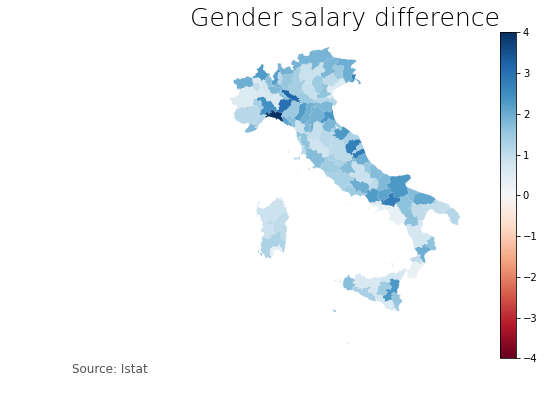

In [14]:
vmax = 0
for year in range(2014,2018):
    merged[f'merged_{year}'] = GeoDataFrame(merged[f'merged_{year}'])
    temp = round(merged[f'merged_{year}']['Value'].abs().max())
    if temp > vmax: vmax = temp

vmin, vcenter = -vmax, 0           # set the range for the choropleth

variable = 'Value'
color_map = 'RdBu'

fig, ax = plt.subplots(1, figsize=(10, 6))  # create figure and axes for Matplotlib
ax.axis('off')  # remove the axis
ax.set_title('Gender salary difference', fontdict={'fontsize': '25', 'fontweight' : '3'}) # add a title

# create an annotation for the data source
ax.annotate('Source: Istat', xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left',
    verticalalignment='top', fontsize=12, color='#555555')

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

merged[f'merged_2015'].plot(column=variable, cmap=color_map, linewidth=0.01, ax=ax, edgecolor='0.8', norm=norm)

sm = plt.cm.ScalarMappable(norm=norm, cmap=color_map)
cbar = fig.colorbar(sm)                                     # add the colorbar to the figure

# fig.savefig('map_export.png', dpi=300)        #saving our map as .png file.

## Question 2
In private companies, are salaries higher in northern Italy than in the south? (Where do people earn more? Maybe divide by principal/worker/apprentice)

## Question 3
What are the sectors for which the salaries in private companies are highest in Italy?

In [15]:
import plotly.graph_objects as go

df_sectors = df_sectors.query('Sesso=="totale" & `Classe di età`=="totale" & \
                              `Classe di dipendenti`=="totale" & `Qualifica contrattuale`=="totale"')[['Ateco 2007','TIME','Value']]
df_sectors

,Ateco 2007,TIME,Value
40,estrazione di minerali da cave e miniere,2014,22.00
41,estrazione di minerali da cave e miniere,2015,21.44
42,estrazione di minerali da cave e miniere,2016,21.54
43,estrazione di minerali da cave e miniere,2017,21.58
104,attività manifatturiere,2014,14.82
...,...,...,...
969,"attività professionali, scientifiche e tecniche",2017,16.20
1107,altre attività di servizi,2014,9.44
1108,altre attività di servizi,2015,9.77
1109,altre attività di servizi,2016,9.91


In [16]:
import plotly.graph_objects as go

for year in range(2014,2018):
    tmp = df_sectors.query(f'TIME=={year}').sort_values(by='Value')
    fig = go.Figure(go.Bar(
                y = tmp["Ateco 2007"],
                x = tmp['Value'],
                orientation='h')
            )

    # fig.show()

del tmp

In [17]:
howManyEls = 2  # TODO : how many values to show

for year in range(2014,2018):
    tmp = df_sectors.query(f'TIME=={year}').sort_values(by='Value')
    tmp_top = tmp.head(howManyEls)
    tmp_bottom = tmp.tail(howManyEls)
    sectorNames = tmp_top["Ateco 2007"].tolist() + ["others"] + tmp_bottom["Ateco 2007"].tolist()
    sectorValues = tmp_top["Value"].tolist() + [ round(np.average(tmp.head(-howManyEls).tail(-howManyEls)["Value"]),2) ] + tmp_bottom["Value"].tolist()
    fig = go.Figure(go.Bar(
                y = sectorNames,
                x = sectorValues,
                orientation='h')
            )

    # Labeling bars
    annotations = []
    for yd, xd in zip(sectorNames, sectorValues):
        annotations.append(dict(xref='x', yref='y',
                                x=xd-1, y=yd,
                                text=str(xd),    # TODO : €/hr on y axis (is the unit)
                                font=dict(family='Arial', size=14,
                                          color='rgb(255, 255, 255)'),    # TODO : check contrast (for font-colors) and change fonts and re-arrange the figure (size etc..)
                                showarrow=False))

    fig.update_layout(
        xaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=False,
            zeroline=False,
            domain=[0.15, 1]
        ),
        yaxis=dict(
            showgrid=False,
            showline=False,
            # showticklabels=False,
            zeroline=False,
        ),
        paper_bgcolor='rgb(248, 248, 255)',
        plot_bgcolor='rgb(248, 248, 255)',
        annotations = annotations
    )
    fig.show()

del tmp, tmp_top, tmp_bottom, sectorNames, sectorValues

# TODO : all labels are written in Italian...
# TODO : we choose to show actual data for top 3 and last 3 sectors and collapse all others in "other",
#           by computing the average.. can we do something different? E.g. a different plot for top 3 and last 3?
#           What about comparing values in different years?